In [2]:
# see which are the main topics through the years. 
import os
import duckdb
import pyarrow.parquet as pq

def create_filtered_database_connection(parquet_directory: str, table_name: str, columns: list, min_score: int, min_post_length: int, start_date: int, end_date: int, max_expression_depth: int = 2500) -> duckdb.DuckDBPyConnection:
    """Create a filtered database connection and load only the necessary data."""
    # List all files in the directory
    all_files = os.listdir(parquet_directory)
    
    valid_files = []
    for file in all_files:
        file_path = f'{parquet_directory}/{file}'
        try:
            # Read the schema of the Parquet file
            parquet_file = pq.ParquetFile(file_path)
            schema = parquet_file.schema.to_arrow_schema()
            # Check if 'media' field exists and is of boolean type
            if schema.get_field_index('media') != -1 and schema.field('media').type == 'bool':
                valid_files.append(file)
            del parquet_file
        except Exception as e:
            print(f"Error reading schema of file {file}: {e}")
    
    # print(valid_files)
    files = [f'{parquet_directory}/{file}' for file in valid_files]
    con = duckdb.connect(database=':memory:')
    con.execute(f"SET max_expression_depth TO {max_expression_depth}")
    query_files = ', '.join(f"'{f}'" for f in files)
    
    # Define the schema with the specified columns
    columns_str = ', '.join(columns)
    
    # only load in the database what is necessary
    sql_query = f"""
    CREATE TABLE {table_name} AS 
    SELECT {columns_str} 
    FROM read_parquet([{query_files}], union_by_name=True)
    WHERE LENGTH(title) > {min_post_length}
      AND score > {min_score}
      AND selftext NOT LIKE '%[deleted]%'
      AND selftext NOT LIKE '%[removed]%'
      AND media = FALSE 
      AND {start_date} < created_utc 
      AND created_utc < {end_date}
    """
    
    try:
        con.execute(sql_query)
    except duckdb.ConversionException as e:
        print(f"Error creating table {table_name}: {e}")
        raise
    
    return con

In [4]:
# Database configuration and parameters for filtering
TABLE_NAME = 'submissions'
MIN_SCORE = 10
MIN_POST_LENGTH = 40
START_DATE= 1199179770 # 2008-01-01
END_DATE= 1672531200 # 2023-01-01

con = create_filtered_database_connection('../data/big_test', TABLE_NAME, ['id', 'title', 'selftext', 'created_utc', 'score', 'media'], MIN_SCORE, MIN_POST_LENGTH, START_DATE, END_DATE)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [35]:
# load ids from output/testing_pipeline/reddit_data.h5
import h5py
import numpy as np
import pandas as pd

with h5py.File('../output/testing_pipeline/reddit_data.h5', 'r') as f:
    ids = f['ids'][:]
    clusters = f['clusters'][:]

ids_list = ids.tolist()

clusters.resize(1, len(clusters))
ids.resize(1, len(ids))
decoded_ids = np.vectorize(lambda x: x.decode('utf-8'))(ids)

query = f"""
    SELECT id, created_utc
    FROM {TABLE_NAME}
    WHERE id IN ({','.join(['?']*len(ids_list))})
"""
df = con.execute(query, ids_list).fetchdf()

# # Step 4: Ensure that the retrieved elements are in the same order as the ids array
# df_sorted = pd.DataFrame(ids, columns=['id']).merge(df, on='id', how='left')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [47]:
concatenated = np.concatenate([clusters, decoded_ids], axis=0)
cluster_ids = pd.DataFrame(concatenated.T, columns=['cluster', 'id'])

df = df.merge(cluster_ids, on='id', how='left')
df

,id,created_utc,cluster
0,5n19ct,1484004675,-1
1,5n19cy,1484004676,-1
2,5n19dl,1484004681,-1
3,5n19dx,1484004683,34
4,5n19e4,1484004683,-1
...,...,...,...
9597645,7iakx7,1512689595,34
9597646,7iakxd,1512689596,-1
9597647,7iakxq,1512689597,44
9597648,7iaky8,1512689600,-1


/tmp/ipykernel_1175961/2884395155.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_clusters['month'] = df_top_clusters['created_utc'].dt.to_period('M')


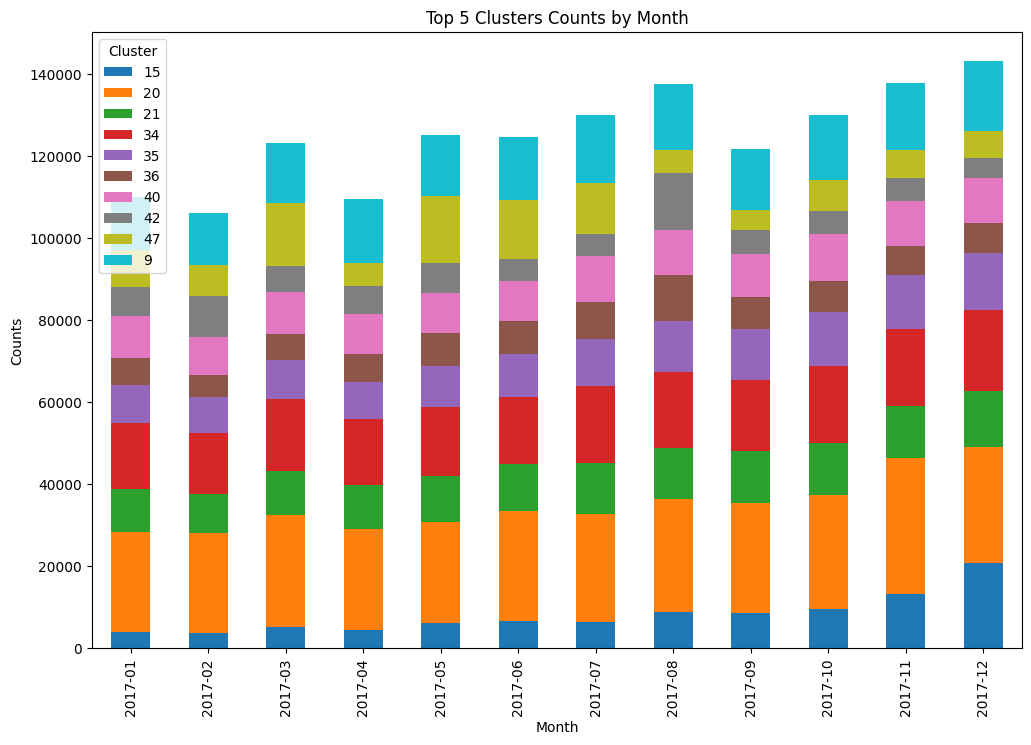

In [59]:
import pandas as pd
import matplotlib.pyplot as plt



df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')


# Filter out cluster -1
df_filtered = df[df['cluster'] != '-1']

# Find the top 5 clusters
top_clusters = df_filtered['cluster'].value_counts().head(10).index

# Filter the DataFrame to include only the top clusters
df_top_clusters = df_filtered[df_filtered['cluster'].isin(top_clusters)]

# The 'month' column needs to be added to df_top_clusters as well
df_top_clusters['month'] = df_top_clusters['created_utc'].dt.to_period('M')

# Group by month and cluster to count occurrences
cluster_counts_monthly = df_top_clusters.groupby(['month', 'cluster']).size().unstack(fill_value=0)

# Plotting
cluster_counts_monthly.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Top 5 Clusters Counts by Month')
plt.xlabel('Month')
plt.ylabel('Counts')
plt.legend(title='Cluster')
plt.show()


In [2]:
import json

with open('../output/testing_different_subsets/coherence.json', 'r') as f:
    coherence = json.load(f)

overall_coherences = [(c['tf_idf_file'], c['overall_coherence'] )for c in coherence]

overall_coherences

[('output/testing_different_subsets/tf_idfs/tfids_0.01.json',
  -3.70381145628456),
 ('output/testing_different_subsets/tf_idfs/tfids_0.1.json',
  -3.8060282763252786),
 ('output/testing_different_subsets/tf_idfs/tfids_0.2.json',
  -4.0540415265285015),
 ('output/testing_different_subsets/tf_idfs/tfids_0.4.json',
  -3.906504023168239),
 ('output/testing_different_subsets/tf_idfs/tfids_0.6.json',
  -4.076385702123595),
 ('output/testing_different_subsets/tf_idfs/tfids_0.8.json',
  -4.598891303504314),
 ('output/testing_different_subsets/tf_idfs/tfids_0.9.json',
  -3.929337699830228),
 ('output/testing_different_subsets/tf_idfs/tfids_1.0.json',
  -5.189240155933284),
 ('output/testing_different_subsets/tf_idfs/tfids_0.001.json',
  -3.203857735160507),
 ('output/testing_different_subsets/tf_idfs/tfids_0.001.json',
  -2.9927234818255286),
 ('output/testing_different_subsets/tf_idfs/tfids_0.01.json',
  -2.991851793422402),
 ('output/testing_different_subsets/tf_idfs/tfids_0.001.json',
  -3.

In [6]:
coherence

[{'tf_idf_file': 'output/testing_different_subsets/tf_idfs/tfids_0.001.json',
  'date': '2024-07-31T17:03:11.445117',
  'coherence_per_topic': [-1.5125319639322738, -2.087031134657111],
  'overall_coherence': -1.7997815492946923},
 {'tf_idf_file': 'output/testing_different_subsets/tf_idfs/tfids_0.01.json',
  'date': '2024-07-31T17:04:23.168598',
  'coherence_per_topic': [-3.0876578239318118,
   -2.8987230297940867,
   -2.653709093329577,
   -3.2295664179766543,
   -3.978337985764802,
   -2.9036543112888697,
   -3.1962992852206034,
   -1.8625490524758046,
   -1.9954127735436424,
   -2.1111641083541213,
   -2.017821749461971,
   -1.7063194572228064,
   -2.0315313447238816,
   -2.343034754095387,
   -2.778607468966867,
   -4.004042085571282,
   -3.999122008679625,
   -2.969671761371987,
   -3.4407072982474047,
   -3.229183117892682,
   -2.2244248133315323,
   -2.013915127369093,
   -3.217622749194497,
   -2.8786648558882146,
   -2.9632749836275574,
   -1.4756326139986695,
   -1.7088449496

In [1]:
import h5py



file_path = '../output/testing_pipeline/reddit_data.h5'
db_name = 'embeddings'

with h5py.File(file_path, "r") as file:
    dataset = file[db_name]
    data_block = dataset[:]  # +1 because max_idx is inclusive




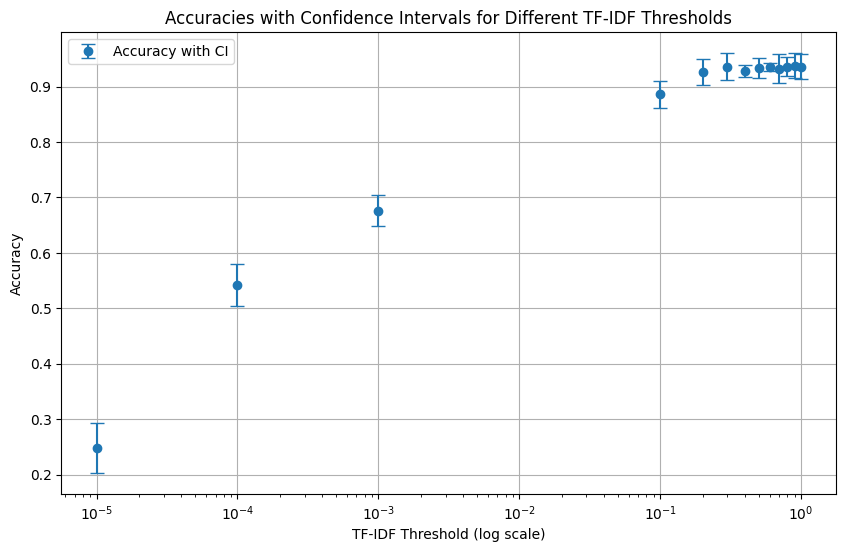

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data from user
data = [
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.00001.json",
        "accuracies": [
            0.28,
            0.29,
            0.19,
            0.18,
            0.3
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.0001.json",
        "accuracies": [
            0.55,
            0.59,
            0.47,
            0.52,
            0.58
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.001.json",
        "accuracies": [
            0.65,
            0.72,
            0.63,
            0.69,
            0.69
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.1.json",
        "accuracies": [
            0.87,
            0.93,
            0.85,
            0.88,
            0.9
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.2.json",
        "accuracies": [
            0.94,
            0.94,
            0.89,
            0.96,
            0.9
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.3.json",
        "accuracies": [
            0.95,
            0.92,
            0.98,
            0.9,
            0.93
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.4.json",
        "accuracies": [
            0.92,
            0.93,
            0.95,
            0.92,
            0.92
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.5.json",
        "accuracies": [
            0.9,
            0.96,
            0.93,
            0.93,
            0.95
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.6.json",
        "accuracies": [
            0.93,
            0.94,
            0.93,
            0.93,
            0.95
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.7.json",
        "accuracies": [
            0.92,
            0.96,
            0.94,
            0.88,
            0.96
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.8.json",
        "accuracies": [
            0.93,
            0.95,
            0.95,
            0.95,
            0.9
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_0.9.json",
        "accuracies": [
            0.92,
            0.96,
            0.97,
            0.94,
            0.9
        ],
        "num_runs": 5
    },
    {
        "tf_idf_file": "output/testing_different_subsets/tf_idfs/tfids_1.0.json",
        "accuracies": [
            0.96,
            0.96,
            0.91,
            0.9,
            0.95
        ],
        "num_runs": 5
    }
]

# Extract x labels and accuracies
x_labels = [float(d["tf_idf_file"].split('_')[-1].split('.json')[0]) for d in data]
accuracies = [d["accuracies"] for d in data]

# Calculate means and confidence intervals
means = [np.mean(acc) for acc in accuracies]
std_devs = [np.std(acc) for acc in accuracies]
conf_intervals = [1.96 * (std / np.sqrt(len(acc))) for std, acc in zip(std_devs, accuracies)]

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(x_labels, means, yerr=conf_intervals, fmt='o', capsize=5, label='Accuracy with CI')
plt.xlabel('TF-IDF Threshold (log scale)')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.title('Accuracies with Confidence Intervals for Different TF-IDF Thresholds')
plt.grid(True)
plt.legend()
plt.show()
